In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import csv
import seaborn as sns

COLUMNS = ['AMB', 'CH4', 'CO', 'NMHC', 'NO', 'NO2',
        'NOx', 'O3', 'PM10', 'PM2.5', 'RAINFALL', 'RH',
        'SO2', 'THC', 'WD_HR', 'WIND_DIR', 'WIND_SPEED', 'WS_HR']

# Read in training set

In [21]:
def read_trainData(filename):
    # 讀入檔案
    raw_data = pd.read_csv(filename, header=None, encoding='utf8')

    # 去除標頭和多餘直行
    row, col = raw_data.shape
    raw_data  = raw_data.iloc[1:row, 3:col]              

    # 去除多餘空格
    raw_data = raw_data.replace(r'\s+', '', regex=True)  

    # 將特殊符號替換為 0
    special_chars = ['#', '*', 'x', 'A']  # 定義需要替換的特殊符號
    raw_data.replace(special_chars, 0.0, inplace=True)

    # 轉換成numpy & 浮點數型別
    data = raw_data.values 
    data = data.astype('float')

    month_to_data = {}  ## Dictionary (key:month , value:data)                                  

    # generate month_to_data(20 days data)
    for month in range(12):
        sample = np.empty(shape = (18 , 480))
        for day in range(20):
            for hour in range(24): 
                sample[:,day * 24 + hour] = data[18 * (month * 20 + day): 18 * (month * 20 + day + 1),hour]
        month_to_data[month] = sample  

    return month_to_data

# 分析圖

In [22]:

def analysis_graph(month_to_data, top_n, threshold, method='top_n'):
    data_features = np.vstack([value.T for value in month_to_data.values()])

    df_data_features = pd.DataFrame(data_features, columns=COLUMNS)
    label = np.array(df_data_features['PM2.5'][9:])
    corr_matrix = df_data_features.corr()


    print(f"================= Feature Selection - {method} =================")
 
    # 获取与 'PM2.5' 的相关性
    pm25_corr = corr_matrix['PM2.5']   
    if method == 'top_n':
        # 排序并找出与 PM2.5 最相关的前 N 个特征
        top_n =  top_n # 设置要找出的前 N 个相关特征
        top_pm25 = pm25_corr.drop('PM2.5').sort_values(ascending=False).head(top_n)
        need_features = top_pm25 
        print(f"與 PM2.5 排名最的前 {top_n} 個特徵：")
        print(top_pm25)

    elif method == 'threshold':
        # 设置一个阈值筛选出高于该值的相关性特征
        threshold = threshold  # 设定阈值 0.3
        high_corr_features = pm25_corr[pm25_corr > threshold].drop('PM2.5').sort_values(ascending=False)
        need_features = high_corr_features 
        print(f"與 PM2.5 相關性大於 {threshold} 的特徵：")
        print(high_corr_features)

    print("================= analysis graph =================")
    f,ax = plt.subplots(figsize=(9,6))
    sns.heatmap(corr_matrix, fmt='.3f', linewidths=0.5, ax=ax, cmap='coolwarm')
    plt.show()
    
    need_features = need_features.index.tolist() 
    return need_features


In [23]:

# input_train_path = '../input_data/train.csv'
# month_to_data = read_trainData(input_train_path)
# need_features = analysis_graph(month_to_data, top_n=17, threshold=0.2, method='threshold')

# Preprocess

In [24]:

def select_features(month_to_data, need_feature_index):
    # 遍历字典并保留每个数组中的指定行
    for key, value in month_to_data.items():
        # 保留指定的行索引
        month_to_data[key] = value[need_feature_index, :]
        
    return month_to_data


In [25]:

# need_feature_index = sorted([COLUMNS.index(feature) for feature in need_features]) + [9] # add PM2.5
# month_to_data = select_features(month_to_data, need_feature_index)

# print(need_features)
# print(need_feature_index)

In [26]:
def SetDataSets(month_to_data, feature_num, PM25_index):
    x = np.empty(shape = (12 * 471 , feature_num * 9),dtype = float)
    y = np.empty(shape = (12 * 471 , 1),dtype = float)

    for month in range(12): 
        for day in range(20): 
            for hour in range(24):   
                if day == 19 and hour > 14:
                    continue  
                x[month * 471 + day * 24 + hour,:] = month_to_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1,-1) 
                y[month * 471 + day * 24 + hour,0] = month_to_data[month][PM25_index ,day * 24 + hour + 9]
    return x, y


In [27]:

# FEATURE_NUM = len(need_feature_index)
# PM25_INDEX = FEATURE_NUM - 1
# x, y = SetDataSets(month_to_data, FEATURE_NUM, PM25_INDEX)
# print(x.shape)
# print(y.shape)
# print(x[0])
# print(y)

In [28]:
def Normalization(x, mean, std):
    x = x - mean
    x = x / std
    return x    


In [29]:


# train_X, valid_X, train_Y, valid_Y = train_test_split(x, y, test_size=0.2, random_state=42)
# MEAN = np.mean(train_X, axis = 0)   #计算每个属性的均值
# STD = np.std(train_X, axis = 0)     #计算每个属性的方差

# train_X = Normalization(train_X, MEAN, STD)
# valid_X = Normalization(valid_X, MEAN, STD)

# print(train_X.shape)
# print(train_Y.shape)     
# print(valid_X.shape)
# print(valid_Y.shape)     

# Linear Regression Agrad

In [30]:
def RMSE(predict_Y, real_Y):
    N = len(predict_Y)  # 樣本數量
    loss = np.sqrt(np.sum((predict_Y - real_Y)**2) / N)
    return loss


In [31]:


# L2 正則化（Ridge）
def traininig_L2(train_X, train_Y, valid_X, valid_Y, epochs, lambda_reg=0.1):
    dim = train_X.shape[1]
    w = np.zeros(shape=(dim, 1))
    learning_rate = np.array([[0.1]] * dim)
    adagrad_sum = np.zeros(shape=(dim, 1))  
    epoch = epochs
    loss_history = np.zeros([epoch, 1])
    loss_val_history = np.zeros([epoch, 1])
    min_loss_val = 0
    print("================= traininig L2 =================")
    
    for T in range(epoch):
        predict_Y = train_X.dot(w)   
        rmse_loss = RMSE(predict_Y, train_Y) + lambda_reg * np.sum(w ** 2)  # L2 正則化項
        loss_history[T] = rmse_loss
        
        # 紀錄驗證集變化
        pre = np.dot(valid_X, w)
        loss_val_history[T] = RMSE(pre, valid_Y) + lambda_reg * np.sum(w ** 2)  # L2 正則化項
        
        if T % 500 == 0:
            print(f"T={T}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[T][0]:.4f}")
        
        if T == 0 or min_loss_val > loss_val_history[T][0]:
            min_loss_val = loss_val_history[T][0]
            np.save(f'weight_L2.npy', w)
            
        # Compute gradient (MSE gradient)
        gradient = 2 * np.dot(np.transpose(train_X), (predict_Y - train_Y)) / len(train_Y)
        
        # Add L2 regularization gradient
        gradient += 2 * lambda_reg * w  # L2 正則化項的梯度
        
        # Update Adagrad sum
        adagrad_sum += gradient ** 2
        Sigma = np.sqrt(adagrad_sum)
     
        # Update weights using Adagrad
        w = w - learning_rate * gradient / (Sigma + 0.0005)

    print(f"T={epochs-1}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[epochs-1][0]:.4f}")
    
    return loss_history, loss_val_history


# L1 正則化（Lasso）
def traininig_L1(train_X, train_Y, valid_X, valid_Y, epochs, lambda_reg=0.1):
    dim = train_X.shape[1]
    w = np.zeros(shape=(dim, 1))
    learning_rate = np.array([[0.1]] * dim)
    adagrad_sum = np.zeros(shape=(dim, 1))  
    epoch = epochs
    loss_history = np.zeros([epoch, 1])
    loss_val_history = np.zeros([epoch, 1])
    min_loss_val = 0
    print("================= traininig L1 =================")
    
    for T in range(epoch):
        predict_Y = train_X.dot(w)   
        rmse_loss = RMSE(predict_Y, train_Y) + lambda_reg * np.sum(np.abs(w))  # L1 正則化項
        loss_history[T] = rmse_loss
        
        # 紀錄驗證集變化
        pre = np.dot(valid_X, w)
        loss_val_history[T] = RMSE(pre, valid_Y) + lambda_reg * np.sum(np.abs(w))  # L1 正則化項
        
        if T % 500 == 0:
            print(f"T={T}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[T][0]:.4f}")
        
        if T == 0 or min_loss_val > loss_val_history[T][0]:
            min_loss_val = loss_val_history[T][0]
            np.save(f'weight_L1.npy', w)
            
        # Compute gradient (MSE gradient)
        gradient = 2 * np.dot(np.transpose(train_X), (predict_Y - train_Y)) / len(train_Y)
        
        # Add L1 regularization gradient
        gradient += lambda_reg * np.sign(w)  # L1 正則化項的梯度
        
        # Update Adagrad sum
        adagrad_sum += gradient ** 2
        Sigma = np.sqrt(adagrad_sum)
     
        # Update weights using Adagrad
        w = w - learning_rate * gradient / (Sigma + 0.0005)

    print(f"T={epochs-1}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[epochs-1][0]:.4f}")
    
    return loss_history, loss_val_history



# ElasticNet 正則化
def traininig_ElasticNet(train_X, train_Y, valid_X, valid_Y, epochs, lambda_l1=0.1, lambda_l2=0.1):
    dim = train_X.shape[1]
    w = np.zeros(shape=(dim, 1))
    learning_rate = np.array([[0.1]] * dim)
    adagrad_sum = np.zeros(shape=(dim, 1))  
    epoch = epochs
    loss_history = np.zeros([epoch, 1])
    loss_val_history = np.zeros([epoch, 1])
    min_loss_val = 0
    print("================= traininig ElasticNet =================")
    
    for T in range(epoch):
        predict_Y = train_X.dot(w)   
        rmse_loss = RMSE(predict_Y, train_Y) + lambda_l1 * np.sum(np.abs(w)) + lambda_l2 * np.sum(w ** 2)  # ElasticNet 正則化項
        loss_history[T] = rmse_loss
        
        # 紀錄驗證集變化
        pre = np.dot(valid_X, w)
        loss_val_history[T] = RMSE(pre, valid_Y) + lambda_l1 * np.sum(np.abs(w)) + lambda_l2 * np.sum(w ** 2)  # ElasticNet 正則化項
        
        if T % 500 == 0:
            print(f"T={T}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[T][0]:.4f}")
        
        if T == 0 or min_loss_val > loss_val_history[T][0]:
            min_loss_val = loss_val_history[T][0]
            np.save(f'weight_ElasticNet.npy', w)
            
        # Compute gradient (MSE gradient)
        gradient = 2 * np.dot(np.transpose(train_X), (predict_Y - train_Y)) / len(train_Y)
        
        # Add ElasticNet regularization gradient
        gradient += lambda_l1 * np.sign(w) + 2 * lambda_l2 * w  # ElasticNet 正則化項的梯度
        
        # Update Adagrad sum
        adagrad_sum += gradient ** 2
        Sigma = np.sqrt(adagrad_sum)
     
        # Update weights using Adagrad
        w = w - learning_rate * gradient / (Sigma + 0.0005)

    print(f"T={epochs-1}, Training Loss: {rmse_loss:.4f}, Validation Loss: {loss_val_history[epochs-1][0]:.4f}")
    
    return loss_history, loss_val_history


In [32]:
def graph_val_Train(epochs, loss_history, loss_val_history):
    epoch = np.arange(epochs)
    plt.plot(epoch, loss_history)
    plt.plot(epoch, loss_val_history) 
    plt.show()

# predict valid

In [33]:
def validation(valid_X, valid_Y, weightPath):
    w = np.load(weightPath) 
    print(w.shape)  
    valid_predict_Y = valid_X.dot(w)

    predict_rmse = RMSE(valid_predict_Y, valid_Y)
    print("================= validation =================")
    for i in range(len(valid_Y)):
        print(f"predict_Y[i], Y[i]: {np.round(valid_predict_Y[i], 0)}, {valid_Y[i]}")
        
    print(f"predict_rmse: {predict_rmse}")
    return predict_rmse
    


# Read in Testing set

In [34]:
def read_testData(filename, feautre_num, need_feature_index):
    # 讀入檔案
    raw_data = pd.read_csv(filename, header=None, encoding='utf8')

    # 去除標頭和多餘直行
    row, col = raw_data.shape
    raw_data  = raw_data.iloc[:, 2:col]              

    # 去除多餘空格
    raw_data = raw_data.replace(r'\s+', '', regex=True)  

    # 將特殊符號替換為 0
    special_chars = ['#', '*', 'x', 'A','WIND_DIR+D2070EC']  # 定義需要替換的特殊符號
    raw_data.replace(special_chars, 0.0, inplace=True)
    
    # 轉換成numpy & 浮點數型別
    data = raw_data.values 
    data = data.astype('float')

    test_row = 244
    test_x = np.empty(shape = (test_row, feautre_num * 9),dtype = float)

    for i in range(test_row):
        features_arr = data[18 * i : 18 * (i+1),:]
        clean_features = features_arr[need_feature_index, :]
        test_x[i, :] = clean_features.reshape(1, -1)


    return test_x


# predict test

In [35]:
def write_result(predict_Y, weightPath):
    name = weightPath.split('.')[0]
    name = name.split('_')[1]
    with open(f'../output/result_{name}.csv', "w", newline='') as f:
        w = csv.writer(f)
        title = ['index','answer']
        w.writerow(title) 
        for i in range(244):
            content = ['index_'+str(i),int(np.round(predict_Y[i][0], 0))]
            w.writerow(content) 
    
    print("write complete!")

In [36]:
def testing(input_test_path, weightPath, feautre_num, need_feature_index, mean, std):
    test_X = read_testData(input_test_path, feautre_num, need_feature_index) 
    test_X = Normalization(test_X, mean, std)
    test_X = np.concatenate((np.ones(shape = (test_X.shape[0],1)),test_X),axis = 1).astype(float)

    print("================= testing =================")
    w = np.load(weightPath) 
    predict_Y = test_X.dot(w)
    write_result(predict_Y, weightPath)


In [37]:
def save_diff_top_n_graph(valid_predict):
    x = np.arange(1,18)
    y = valid_predict
    plt.plot(x, y, 'ro--', linewidth=2, markersize=4)
    plt.savefig('../output/diff_top_n.png')
    plt.show()

def save_diff_test_size_graph(valid_predict, train_predict, x_1):
    x = x_1
    valid_predict.reverse()
    train_predict.reverse()
    y_1 = valid_predict
    y_2 = train_predict
    plt.plot(x, y_1, 'r*--', linewidth=1, markersize=4)
    plt.plot(x, y_2, 'b*--', linewidth=1, markersize=4)
    plt.savefig('../output/diff_training_DataSets.png')
    plt.show()
    
    for i in range(len(x)):
        print(f"DataSets: {round(x[i], 2)}, valid_predict: {valid_predict[i]}, train_predict: {train_predict[i]}")


# main

================= Feature Selection - threshold =================
與 PM2.5 相關性大於 0.2 的特徵：
PM10    0.816310
CO      0.600925
NMHC    0.511133
NO2     0.499470
NOx     0.463238
THC     0.303378
SO2     0.297900
NO      0.233854
CH4     0.218112
Name: PM2.5, dtype: float64
================= analysis graph =================


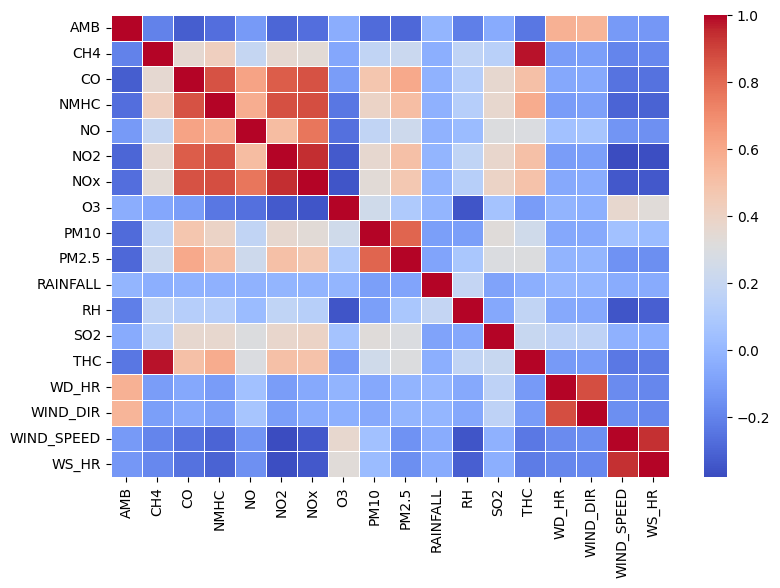

0.0001
================= traininig L2 =================
T=0, Training Loss: 16.8256, Validation Loss: 16.9989
T=500, Training Loss: 10.6335, Validation Loss: 10.6249
T=1000, Training Loss: 9.1754, Validation Loss: 9.2381
T=1500, Training Loss: 8.1784, Validation Loss: 8.3008
T=2000, Training Loss: 7.4240, Validation Loss: 7.5961
T=2500, Training Loss: 6.8274, Validation Loss: 7.0422
T=3000, Training Loss: 6.3449, Validation Loss: 6.5969
T=3500, Training Loss: 5.9497, Validation Loss: 6.2349
T=4000, Training Loss: 5.6239, Validation Loss: 5.9387
T=4500, Training Loss: 5.3543, Validation Loss: 5.6957
T=5000, Training Loss: 5.1311, Validation Loss: 5.4963
T=5500, Training Loss: 4.9462, Validation Loss: 5.3327
T=6000, Training Loss: 4.7933, Validation Loss: 5.1986
T=6500, Training Loss: 4.6670, Validation Loss: 5.0889
T=7000, Training Loss: 4.5628, Validation Loss: 4.9993
T=7500, Training Loss: 4.4770, Validation Loss: 4.9264
T=8000, Training Loss: 4.4065, Validation Loss: 4.8670
T=8500, T

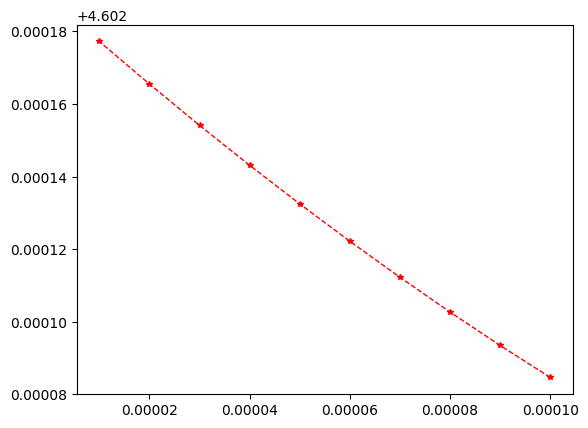

lambda_regs: 0.0001, valid_predict: 4.602084569537726
lambda_regs: 9e-05, valid_predict: 4.602093392660879
lambda_regs: 8e-05, valid_predict: 4.602102606701626
lambda_regs: 7e-05, valid_predict: 4.602112203080918
lambda_regs: 6e-05, valid_predict: 4.602122129027454
lambda_regs: 5e-05, valid_predict: 4.602132435748303
lambda_regs: 4e-05, valid_predict: 4.60214308545326
lambda_regs: 3e-05, valid_predict: 4.6021540918483
lambda_regs: 2e-05, valid_predict: 4.6021654964625505
lambda_regs: 1e-05, valid_predict: 4.602177247267417
min_loss: 4.602084569537726, index: 0, lambda_regs: 0.0


In [70]:
if __name__=='__main__':
    input_train_path = '../input_data/train.csv'
    input_test_path = '../input_data/test.csv'    
    valid_predict = []
    train_predict = []
    

    month_to_data = read_trainData(input_train_path)
    need_features = analysis_graph(month_to_data, top_n=17, threshold=0.2, method='threshold')
    
    need_feature_index = sorted([COLUMNS.index(feature) for feature in need_features]) + [9] # add PM2.5
    # need_feature_index = [0,1,2,3,4,5,6,8, 9]
    month_to_data = select_features(month_to_data, need_feature_index)
    

    FEATURE_NUM = len(need_feature_index)
    PM25_INDEX = FEATURE_NUM - 1

    x, y = SetDataSets(month_to_data, FEATURE_NUM, PM25_INDEX)    
    
    # for ratio in np.arange(0.1, 0.9, 0.01):
    ratio = 0.2
    train_X, valid_X, train_Y, valid_Y = train_test_split(x, y, test_size=ratio, random_state=42) #0.25 0.15 0.12
    MEAN = np.mean(train_X, axis = 0)   #计算每个属性的均值
    STD = np.std(train_X, axis = 0)     #计算每个属性的方差

    train_X = Normalization(train_X, MEAN, STD)
    valid_X = Normalization(valid_X, MEAN, STD)


    m, dim = train_X.shape   #获取 X_train 的行数 X_rows 和列数 X_cols
    m_val = len(valid_X)
    dim = dim + 1  #维度加 1 
    train_X = np.concatenate((np.ones([len(train_X),1]),train_X), axis = 1).astype(float)  #在train_X前面加了一列1
    valid_X = np.concatenate((np.ones([len(valid_X),1]),valid_X), axis = 1).astype(float)  #在valid_X前面加了一列1

    epochs = 30000
    # loss_history_L2, loss_val_history_L2 = traininig_L2(train_X, train_Y, valid_X, valid_Y, epochs, lambda_reg=0.001)
    # loss_history_L1, loss_val_history_L1 = traininig_L1(train_X, train_Y, valid_X, valid_Y, epochs, lambda_reg=0.056)
    # loss_history_El, loss_val_history_El = traininig_ElasticNet(train_X, train_Y, valid_X, valid_Y, epochs, lambda_l1=0.1, lambda_l2=0.00001)
    # graph_val_Train(epochs, loss_history_L2, loss_val_history_L2)
    # graph_val_Train(epochs, loss_history_L1, loss_val_history_L1)
    # graph_val_Train(epochs, loss_history_El, loss_val_history_El)


    # weightPaths = ['weight_L2.npy', 'weight_L1.npy', 'weight_ElasticNet.npy']
    # for weightPath in weightPaths: 
    #     predict_rmse = validation(valid_X, valid_Y, weightPath)
    #     valid_predict.append(predict_rmse)
    
    #     testing(input_test_path, weightPath, FEATURE_NUM, need_feature_index, MEAN, STD)
    # print(valid_predict)
  
    # lambda_regs = np.arange(0.1, 0.001, -0.001)
    
    

    lambda_regs = np.arange(0.0001, 0.0000001, -0.00001)
    for lambda_reg in lambda_regs:     
        print(lambda_reg)
        loss_history_L1, loss_val_history_L1 = traininig_L2(train_X, train_Y, valid_X, valid_Y, epochs, lambda_reg=lambda_reg)
        predict_rmse = validation(valid_X, valid_Y, 'weight_L2.npy')
        valid_predict.append(predict_rmse)
    
        testing(input_test_path, 'weight_L2.npy', FEATURE_NUM, need_feature_index, MEAN, STD)
        
    print(valid_predict)
    
    # # 設定標題和軸標籤
    x_11 = lambda_regs
    y_11 = valid_predict
    print(x_11)
    print(y_11)
    plt.plot(x_11, y_11, 'r*--', linewidth=1, markersize=4)
    plt.savefig('../output/lambda_reg_L2_power1.png')
    plt.show()

    # 顯示每個 lambda 組合及對應的預測值
    for i in range(len(x_11)):
        print(f"lambda_regs: {np.round(x_11[i], 7)}, valid_predict: {valid_predict[i]}")


    min_value = min(valid_predict)
    min_index = valid_predict.index(min_value)
    print(f"min_loss: {min_value}, index: {min_index}, lambda_regs: {np.round(x_11[min_index], 3)}")

[0.1   0.099 0.098 0.097 0.096 0.095 0.094 0.093 0.092 0.091 0.09  0.089
 0.088 0.087 0.086 0.085 0.084 0.083 0.082 0.081 0.08  0.079 0.078 0.077
 0.076 0.075 0.074 0.073 0.072 0.071 0.07  0.069 0.068 0.067 0.066 0.065
 0.064 0.063 0.062 0.061 0.06  0.059 0.058 0.057 0.056 0.055 0.054 0.053
 0.052 0.051 0.05  0.049 0.048 0.047 0.046 0.045 0.044 0.043 0.042 0.041
 0.04  0.039 0.038 0.037 0.036 0.035 0.034 0.033 0.032 0.031 0.03  0.029
 0.028 0.027 0.026 0.025 0.024 0.023 0.022 0.021 0.02  0.019 0.018 0.017
 0.016 0.015 0.014 0.013 0.012 0.011 0.01  0.009 0.008 0.007 0.006 0.005
 0.004 0.003 0.002]
[np.float64(4.59662367077078), np.float64(4.59936037575565), np.float64(4.597972931528402), np.float64(4.598878190025892), np.float64(4.59878505703666), np.float64(4.59768596200957), np.float64(4.59923421995397), np.float64(4.5991445655544085), np.float64(4.596956245888576), np.float64(4.601018504341355), np.float64(4.60018669503082), np.float64(4.597794838062742), np.float64(4.596850012431542

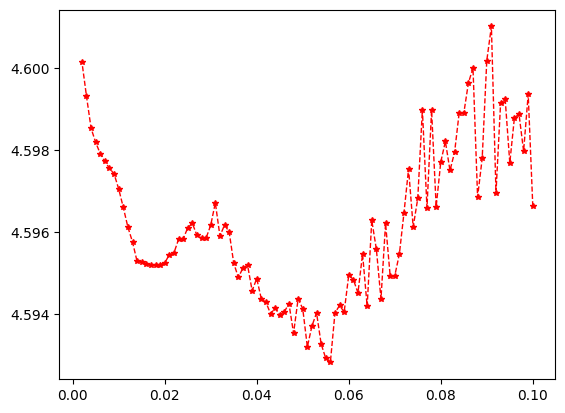

lambda_regs: 0.1, valid_predict: 4.59662367077078
lambda_regs: 0.099, valid_predict: 4.59936037575565
lambda_regs: 0.098, valid_predict: 4.597972931528402
lambda_regs: 0.097, valid_predict: 4.598878190025892
lambda_regs: 0.096, valid_predict: 4.59878505703666
lambda_regs: 0.095, valid_predict: 4.59768596200957
lambda_regs: 0.094, valid_predict: 4.59923421995397
lambda_regs: 0.093, valid_predict: 4.5991445655544085
lambda_regs: 0.092, valid_predict: 4.596956245888576
lambda_regs: 0.091, valid_predict: 4.601018504341355
lambda_regs: 0.09, valid_predict: 4.60018669503082
lambda_regs: 0.089, valid_predict: 4.597794838062742
lambda_regs: 0.088, valid_predict: 4.596850012431542
lambda_regs: 0.087, valid_predict: 4.600004715291466
lambda_regs: 0.086, valid_predict: 4.599635581605103
lambda_regs: 0.085, valid_predict: 4.598896749566004
lambda_regs: 0.084, valid_predict: 4.598910662162931
lambda_regs: 0.083, valid_predict: 4.597943708144542
lambda_regs: 0.082, valid_predict: 4.597499697467194
l

In [ ]:
# # # 設定標題和軸標籤
# x_11 = lambda_regs
# y_11 = valid_predict
# print(x_11)
# print(y_11)
# plt.plot(x_11, y_11, 'r*--', linewidth=1, markersize=4)
# plt.savefig('../output/lambda_reg_L1_power1.png')
# plt.show()

# # 顯示每個 lambda 組合及對應的預測值
# for i in range(len(x_11)):
#     print(f"lambda_regs: {np.round(x_11[i], 3)}, valid_predict: {valid_predict[i]}")


# min_value = min(valid_predict)
# min_index = valid_predict.index(min_value)
# print(f"min_loss: {min_value}, index: {min_index}, lambda_regs: {np.round(x_11[min_index], 3)}")